In [2]:
import tensorflow as tf
from tensorflow.keras import models,layers 
import matplotlib.pyplot as plt

In [4]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3

In [5]:
df=tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage", shuffle=True, image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE,
)

Found 2152 files belonging to 3 classes.


In [6]:
class_names=df.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

(256, 256, 3)


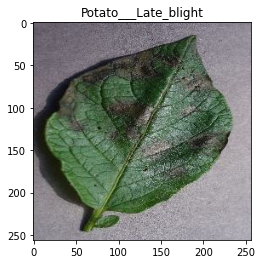

In [7]:
for image_batch, label_batch in df.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[label_batch[0]])
    print(image_batch[0].shape)

In [8]:
def train_test_split(df,train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert(train_split+test_split+val_split)==1
    
    df_size=len(df);
    if shuffle:
        df=df.shuffle(shuffle_size,seed=12)
    train_size=int(train_split*df_size)
    val_size=int(val_split*df_size)
    train_ds=df.take(train_size)
    val_ds=df.skip(train_size).take(val_size)
    test_ds=df.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

train_df,val_df,test_df=train_test_split(df)

In [9]:
train_df=train_df.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_df=val_df.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_df=test_df.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [11]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [12]:
n_classes=3
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu', input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS))

In [13]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [14]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), metrics=['accuracy'])

In [15]:
history=model.fit(
         train_df,
         epochs=50,
         batch_size=BATCH_SIZE,
         verbose=1,
         validation_data=val_df
)

Epoch 1/50
54/54 [==============================] - 105s 2s/step - loss: 0.9001 - accuracy: 0.5156 - val_loss: 0.7790 - val_accuracy: 0.6927
Epoch 2/50
54/54 [==============================] - 95s 2s/step - loss: 0.6521 - accuracy: 0.7199 - val_loss: 0.6780 - val_accuracy: 0.7240
Epoch 3/50
54/54 [==============================] - 93s 2s/step - loss: 0.4683 - accuracy: 0.8067 - val_loss: 0.4024 - val_accuracy: 0.8333
Epoch 4/50
54/54 [==============================] - 93s 2s/step - loss: 0.3820 - accuracy: 0.8356 - val_loss: 0.3039 - val_accuracy: 0.8854
Epoch 5/50
54/54 [==============================] - 97s 2s/step - loss: 0.2757 - accuracy: 0.8941 - val_loss: 0.2141 - val_accuracy: 0.9219
Epoch 6/50
54/54 [==============================] - 93s 2s/step - loss: 0.2712 - accuracy: 0.8900 - val_loss: 0.2143 - val_accuracy: 0.9323
Epoch 7/50
54/54 [==============================] - 95s 2s/step - loss: 0.1895 - accuracy: 0.9277 - val_loss: 0.2314 - val_accuracy: 0.9062
Epoch 8/50
54/54 [=

In [17]:
score=model.evaluate(test_df)

8/8 [==============================] - 4s 315ms/step - loss: 0.1282 - accuracy: 0.9688


In [18]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']


In [24]:
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)
    
    predictions=model.predict(img_array)
    
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    
    return predicted_class,confidence
    

1/1 [==============================] - 0s 33ms/step


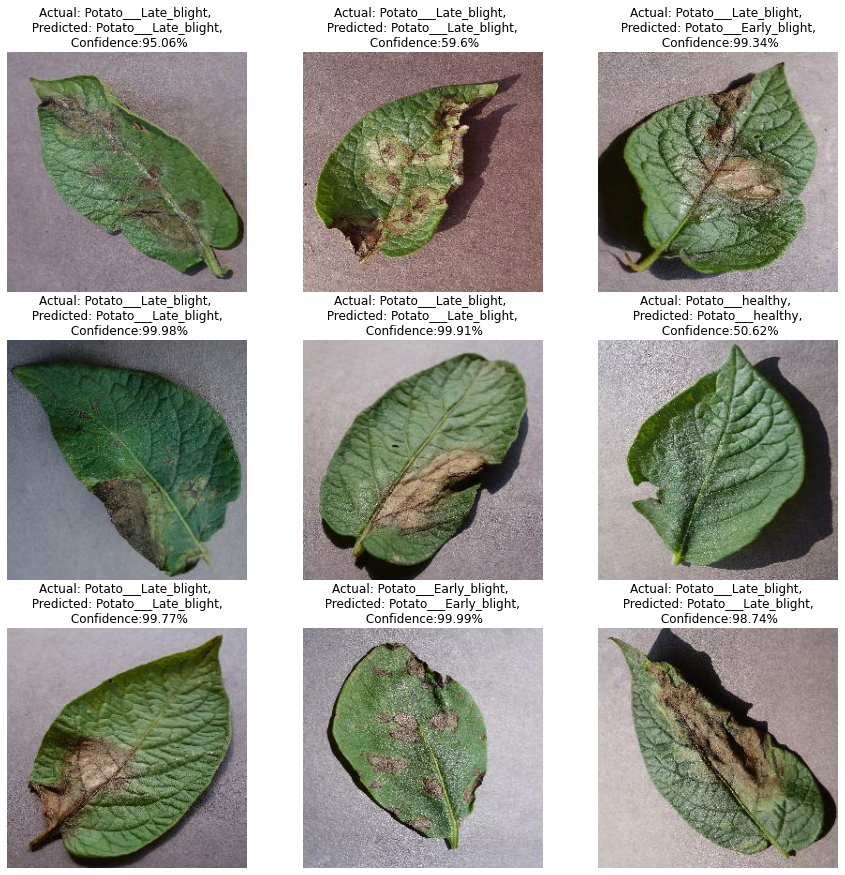

In [32]:
import numpy as np
plt.figure(figsize=(15,15))
for images, labels in test_df.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence=predict(model,images[i].numpy())
        actual_class=class_names[labels[i]]
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}, \n Confidence:{confidence}%")
        plt.axis("off")

In [33]:
model_version=1
model.save(f"../saved_models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets
